In [1]:
import os
import gc

os.chdir('../../')

In [2]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss, roc_auc_score, average_precision_score, brier_score_loss
import joblib
from venn_abers import VennAbersCalibrator
from global_code.util import clf_metric_report, plot_pr_calib_curve, plot_dis_probs
import json

d:\Files\repositorios\modern-ml\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load the calibration data

In [3]:
train_df = pd.read_parquet('./week_1/data/processed/train_df_v2.parquet')
validation_df = pd.read_parquet('./week_1/data/processed/validation_df_v2.parquet')
calibration_df = pd.read_parquet('./week_1/data/processed/calibration_df_v2.parquet')
cat_features = ['country', 'broad_job_category']

target = 'churn_420'

# Input variables and Target dataframes
X_train, y_train= train_df.drop(target, axis=1), train_df.loc[:, target]
X_validation, y_validation= validation_df.drop(target, axis=1), validation_df.loc[:, target]
X_calibration, y_calibration= calibration_df.drop(target, axis=1), calibration_df.loc[:, target]

# Freeing memory
train_df = None
calibration_df = None
validation_df = None
gc.collect()

print('Train Shape: ', X_train.shape, y_train.shape)
print('Validation shape: ', X_validation.shape, y_validation.shape)
print('Calibration shape: ', X_calibration.shape, y_calibration.shape)

Train Shape:  (306649, 183) (306649,)
Validation shape:  (283510, 183) (283510,)
Calibration shape:  (70878, 183) (70878,)


### Loading models

In [4]:
# Base model
# Load the baseline and feature selection models
baseline_model_path = './week_1/model/baseline_model.joblib'
feat_selection_model_path = './week_1/model/feat_selection_model.joblib'
tunned_model_path = './week_1/model/tunned_model.joblib'

baseline_model = joblib.load(baseline_model_path)
feat_selection_model = joblib.load(feat_selection_model_path)
tunned_model = joblib.load(tunned_model_path) 

champion_model = feat_selection_model

In [5]:
selected_features = None
with open('./week_1/model/selected_features_list.json', 'r') as f:
    selected_features = json.load(f)
print(selected_features)

['interest_rate', 'tenure', 'prior_10D_mean_days_between', 'prior_10D_mean_bank_transfer_in_volume', 'prior_90D_sum_days_between', 'prior_90D_max_days_between', 'prior_90D_min_days_between', 'prior_180D_sum_days_between', 'prior_180D_mean_days_between', 'prior_180D_max_days_between', 'prior_180D_min_days_between', 'prior_365D_sum_days_between', 'prior_365D_mean_days_between', 'prior_450D_sum_days_between', 'prior_450D_mean_days_between', 'prior_450D_std_days_between', 'prior_450D_max_days_between', 'prior_450D_mean_balance', 'prior_sum_days_between', 'prior_std_days_between', 'prior_mean_days_between', 'prior_max_days_between', 'prior_mean_bank_transfer_in', 'prior_mean_bank_transfer_out', 'prior_mean_bank_transfer_in_volume', 'prior_sum_crypto_in_volume', 'prior_crypto_balance', 'prior_mean_balance', 'country', 'broad_job_category']


### Calibrate the model using Platt scaling (sigmoid) and isotonic regression

In [6]:
# Platt scaling (sigmoid)
print('Fitting platt scaling calibration...')
calibrated_model_sigmoid = CalibratedClassifierCV(champion_model, method='sigmoid')
calibrated_model_sigmoid.fit(X_calibration[selected_features], y_calibration)
y_pred_sigmoid = calibrated_model_sigmoid.predict_proba(X_validation[selected_features])[:, 1]


Fitting platt scaling calibration...
0:	learn: 0.0302923	total: 440ms	remaining: 7m 19s
1:	learn: 0.0326844	total: 740ms	remaining: 6m 9s
2:	learn: 0.0354929	total: 1.03s	remaining: 5m 41s
3:	learn: 0.0405590	total: 1.35s	remaining: 5m 35s
4:	learn: 0.0427026	total: 1.58s	remaining: 5m 14s
5:	learn: 0.0431407	total: 1.8s	remaining: 4m 58s
6:	learn: 0.0433357	total: 2.04s	remaining: 4m 49s
7:	learn: 0.0466207	total: 2.24s	remaining: 4m 37s
8:	learn: 0.0470163	total: 2.48s	remaining: 4m 32s
9:	learn: 0.0464385	total: 2.64s	remaining: 4m 21s
10:	learn: 0.0459037	total: 2.79s	remaining: 4m 10s
11:	learn: 0.0450025	total: 3s	remaining: 4m 7s
12:	learn: 0.0472348	total: 3.21s	remaining: 4m 4s
13:	learn: 0.0465231	total: 3.36s	remaining: 3m 56s
14:	learn: 0.0482487	total: 3.57s	remaining: 3m 54s
15:	learn: 0.0488983	total: 3.86s	remaining: 3m 57s
16:	learn: 0.0488686	total: 4s	remaining: 3m 51s
17:	learn: 0.0487228	total: 4.11s	remaining: 3m 44s
18:	learn: 0.0481544	total: 4.33s	remaining: 3m

In [7]:
# Isotonic regression
print('Fitting isotonic regression calibration...')
calibrated_model_isotonic = CalibratedClassifierCV(champion_model, method='isotonic')
calibrated_model_isotonic.fit(X_calibration[selected_features], y_calibration)
y_pred_isotonic = calibrated_model_isotonic.predict_proba(X_validation[selected_features])[:, 1]

Fitting isotonic regression calibration...
0:	learn: 0.0302923	total: 480ms	remaining: 7m 59s
1:	learn: 0.0326844	total: 843ms	remaining: 7m
2:	learn: 0.0354929	total: 1.14s	remaining: 6m 17s
3:	learn: 0.0405590	total: 1.46s	remaining: 6m 3s
4:	learn: 0.0427026	total: 1.75s	remaining: 5m 47s
5:	learn: 0.0431407	total: 2.08s	remaining: 5m 44s
6:	learn: 0.0433357	total: 2.41s	remaining: 5m 41s
7:	learn: 0.0466207	total: 2.69s	remaining: 5m 33s
8:	learn: 0.0470163	total: 2.98s	remaining: 5m 28s
9:	learn: 0.0464385	total: 3.18s	remaining: 5m 15s
10:	learn: 0.0459037	total: 3.37s	remaining: 5m 3s
11:	learn: 0.0450025	total: 3.66s	remaining: 5m 1s
12:	learn: 0.0472348	total: 3.95s	remaining: 4m 59s
13:	learn: 0.0465231	total: 4.13s	remaining: 4m 50s
14:	learn: 0.0482487	total: 4.35s	remaining: 4m 45s
15:	learn: 0.0488983	total: 4.62s	remaining: 4m 44s
16:	learn: 0.0488686	total: 4.79s	remaining: 4m 37s
17:	learn: 0.0487228	total: 4.92s	remaining: 4m 28s
18:	learn: 0.0481544	total: 5.18s	rema

In [8]:
# Compute metrics for Platt scaling and isotonic regression
print("Platt Scaling (Sigmoid) Metrics:")
clf_metric_report(y_pred_sigmoid, y_validation)

print("\nIsotonic Regression Metrics:")
clf_metric_report(y_pred_isotonic, y_validation)

Platt Scaling (Sigmoid) Metrics:
Evaluating the model...
ROC AUC: 0.6678246611881552
Brier Score: 0.013683361865720318
Average Precision: 0.025236743255921366
Log Loss: 0.07138925412009041

Isotonic Regression Metrics:
Evaluating the model...
ROC AUC: 0.6664795290822914
Brier Score: 0.013676217548810533
Average Precision: 0.024821526027573183
Log Loss: 0.07104706071831463


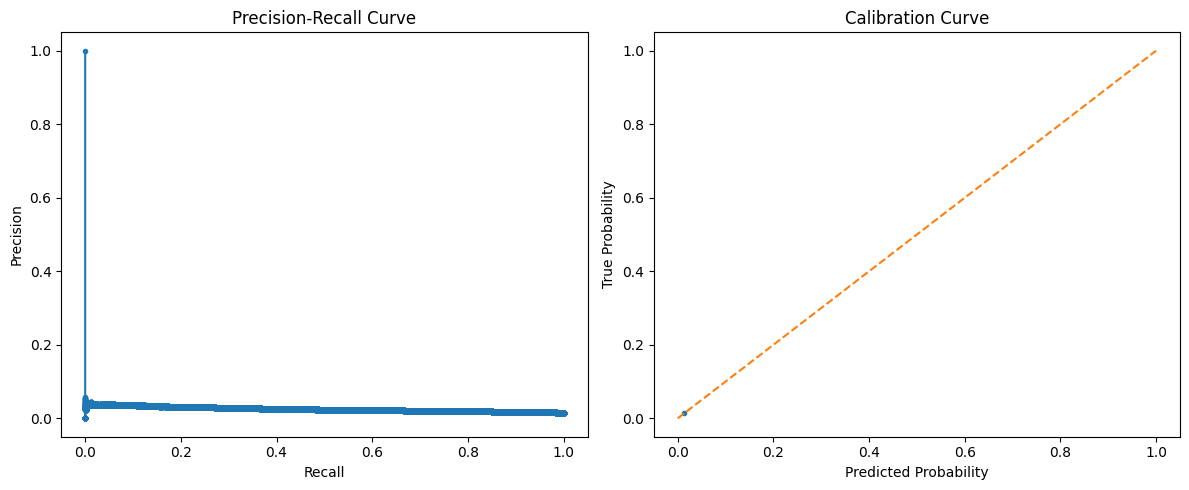

In [9]:
# Plot the calibration curve
plot_pr_calib_curve(y_pred_sigmoid, y_validation)

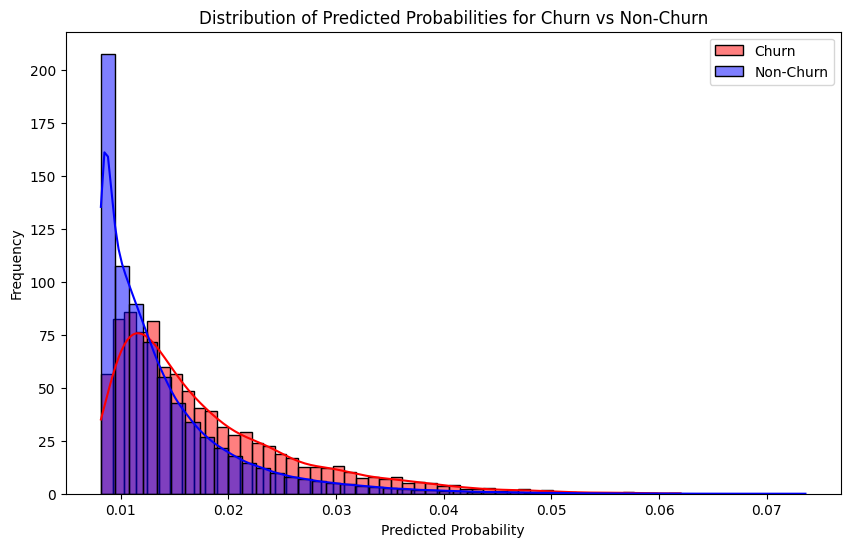

In [10]:
plot_dis_probs(y_pred_sigmoid, y_validation)

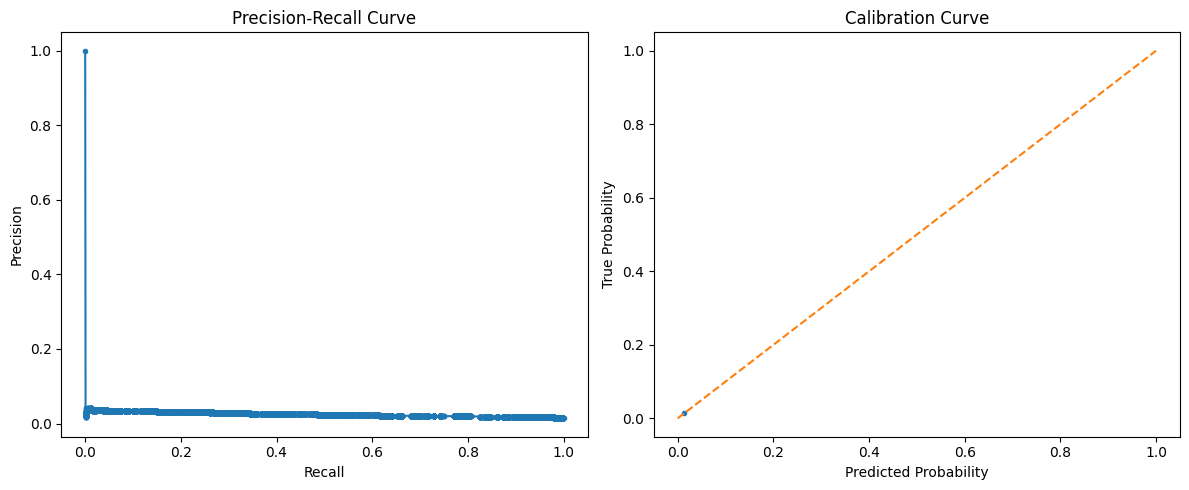

In [11]:
# Plot the calibration curve
plot_pr_calib_curve(y_pred_isotonic, y_validation)

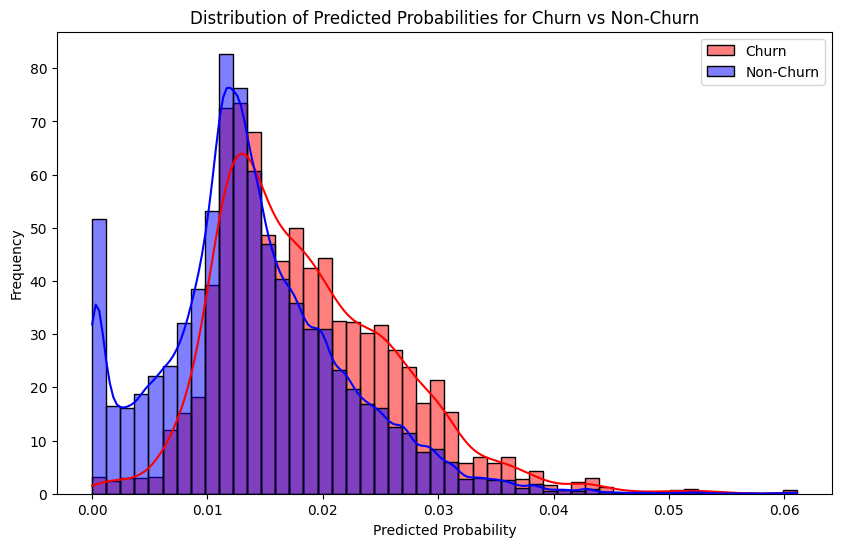

In [12]:
plot_dis_probs(y_pred_isotonic, y_validation)

### Calibrate the model using Venn-Abers

In [13]:
p_cal = tunned_model.predict_proba(X_calibration[selected_features])
p_test = tunned_model.predict_proba(X_validation[selected_features])

va = VennAbersCalibrator()
va_prefit_prob = va.predict_proba(p_cal=p_cal, y_cal=y_calibration.values, p_test=p_test)
y_pred_va = va_prefit_prob[:, 1]

d:\Files\repositorios\modern-ml\.venv\Lib\site-packages\venn_abers\venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:


In [14]:
# Compute metrics for Venn-Abers calibration
print("\nVenn-Abers Calibration Metrics:")
clf_metric_report(y_pred_va, y_validation)


Venn-Abers Calibration Metrics:
Evaluating the model...
ROC AUC: 0.6927100102935472
Brier Score: 0.013642150528233052
Average Precision: 0.029107802473149928
Log Loss: 0.06964082296125726


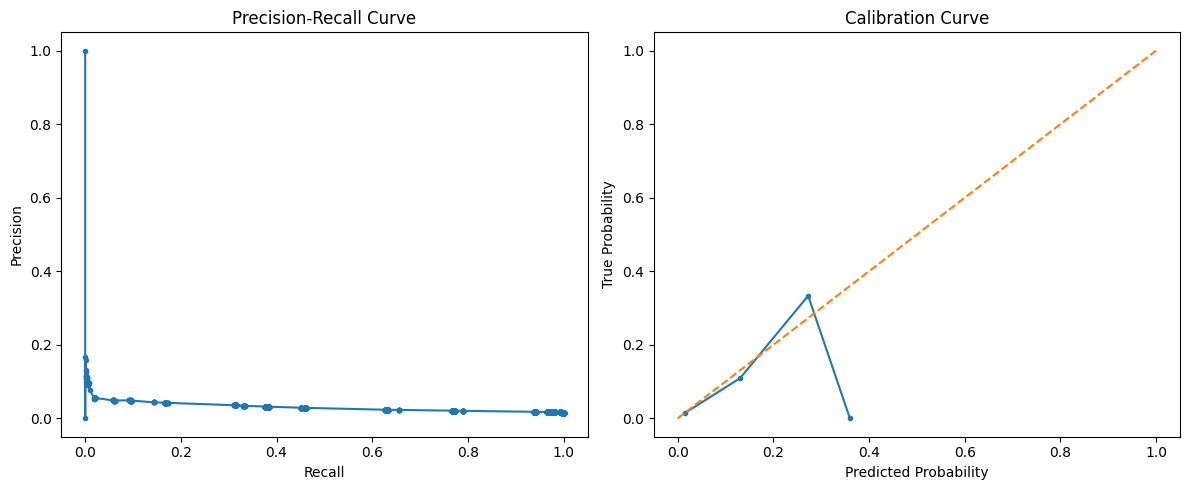

In [15]:
# Plot the calibration curve
plot_pr_calib_curve(y_pred_va, y_validation)

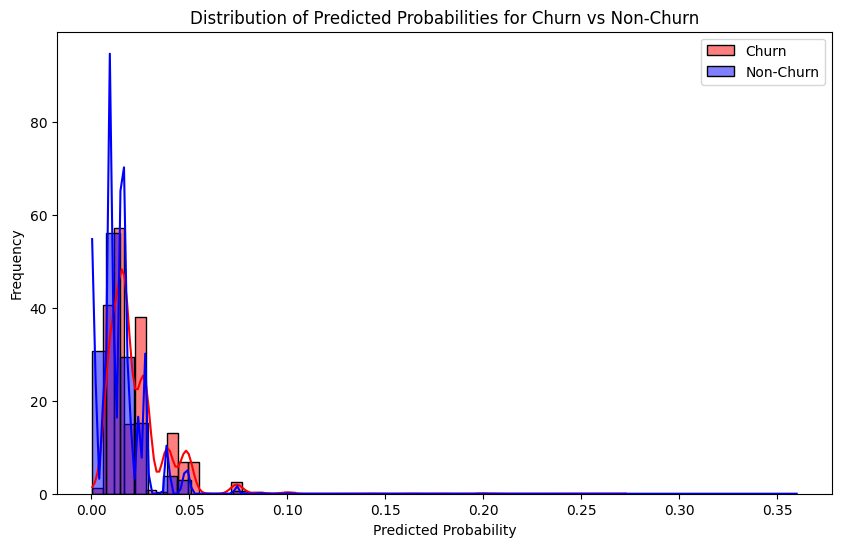

In [16]:
plot_dis_probs(y_pred_va, y_validation)

### Compare the models

In [17]:
# Predict using the baseline model
y_pred_baseline = baseline_model.predict_proba(X_validation)[:, 1]

# Predict using the feature selection model
y_pred_feat_selection = feat_selection_model.predict_proba(X_validation[selected_features])[:, 1]

# Predict using the tunned model
y_pred_tunned= tunned_model.predict_proba(X_validation[selected_features])[:, 1]

# Compare the models using clf_metric_report
print("Baseline Model Metrics:")
clf_metric_report(y_pred_baseline, y_validation)

print("\nFeature Selection Model Metrics:")
clf_metric_report(y_pred_feat_selection, y_validation)

print("\nTuned Model Metrics:")
clf_metric_report(y_pred_tunned, y_validation)

print("\nChampion Platt Scaling (Sigmoid) Metrics:")
clf_metric_report(y_pred_sigmoid, y_validation)

print("\nnChampion Isotonic Regression Metrics:")
clf_metric_report(y_pred_isotonic, y_validation)

print("\nnChampion Venn-Abers Calibration Metrics:")
clf_metric_report(y_pred_va, y_validation)

Baseline Model Metrics:
Evaluating the model...
ROC AUC: 0.6875439449160486
Brier Score: 0.2730737709354388
Average Precision: 0.028297423279297983
Log Loss: 0.7281983181929271

Feature Selection Model Metrics:
Evaluating the model...
ROC AUC: 0.7010793500287231
Brier Score: 0.2791466657487489
Average Precision: 0.031039970123762507
Log Loss: 0.7437834184928249

Tuned Model Metrics:
Evaluating the model...
ROC AUC: 0.694073800885851
Brier Score: 0.02399945941873523
Average Precision: 0.030776730437567037
Log Loss: 0.13471801061485517

Champion Platt Scaling (Sigmoid) Metrics:
Evaluating the model...
ROC AUC: 0.6678246611881552
Brier Score: 0.013683361865720318
Average Precision: 0.025236743255921366
Log Loss: 0.07138925412009041

nChampion Isotonic Regression Metrics:
Evaluating the model...
ROC AUC: 0.6664795290822914
Brier Score: 0.013676217548810533
Average Precision: 0.024821526027573183
Log Loss: 0.07104706071831463

nChampion Venn-Abers Calibration Metrics:
Evaluating the model..